# Let's settle the debate once and for all with a resnet model that can tell the difference between BB8, C3PO, and R2D2 better than any fake star wars fan (pun intended)!

# Step 1: 1st let us install the dependencies

In [1]:
!pip install -Uqq fastai
!pip install -Uqq utils
!pip install -Uqq fastai duckduckgo_search

# Step 2: Data collection from the internet

### 2.1 Making the search image function that searches images based on given prompt

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=90):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### 2.2 Searching the images to see if the results are good enough
#### 1st let's see the results for bb8

In [3]:

urls = search_images('bb8 photos', max_images=1)
urls[0]

Searching for 'bb8 photos'


'https://wallpapercave.com/wp/wp1831236.jpg'

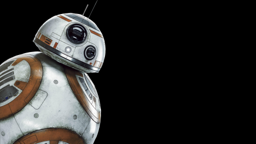

In [4]:
from fastdownload import download_url
dest = 'bb8.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


#### Now for c3po

Searching for 'c3po photos'


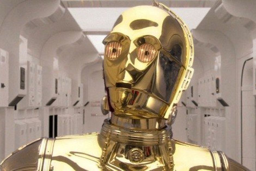

In [5]:
download_url(search_images('c3po photos', max_images=1)[0], 'c3po.jpg', show_progress=False)
Image.open('c3po.jpg').to_thumb(256,256)

#### Now for r2d2

Searching for 'r2d2 photos'


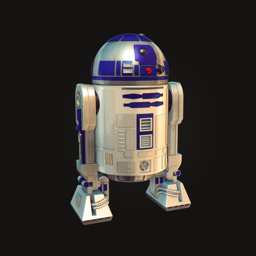

In [6]:
download_url(search_images('r2d2 photos', max_images=1)[0], 'r2d2.jpg', show_progress=False)
Image.open('r2d2.jpg').to_thumb(256,256)

#### Looks like our searches are working good enough. Now let's create three classes with corresponding folders where the pictures will be stored.

### 2.3 Storing the images in individual folders

In [7]:
searches = 'bb8','c3po','r2d2'
path = Path('starwars_iconic_robots')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True) #making directories with name tag
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server

    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bb8 photo'
Searching for 'c3po photo'
Searching for 'r2d2 photo'


# Step 3: Training the Model

### 3.1 Eliminating improper downloads
#### Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

25

### 3.2 Setting the dataloader

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


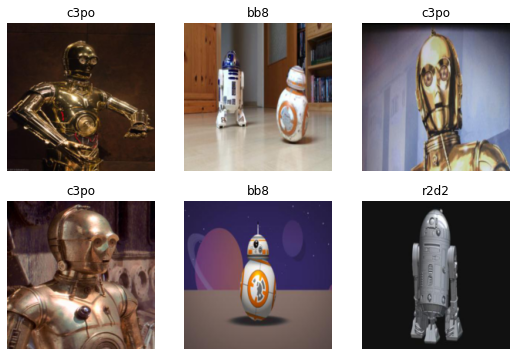

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

### 3.3 Training

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20) #takes the pretrained weights and adjusts them

F:\snake\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
F:\snake\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.051235,0.057293,0.025000,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.115975,0.028787,0.012500,00:40
1,0.080333,0.024295,0.012500,00:42
2,0.056472,0.018708,0.000000,00:42
3,0.051482,0.013968,0.000000,00:40
4,0.047035,0.011419,0.000000,00:42
5,0.048211,0.036574,0.012500,00:42
6,0.042002,0.015879,0.012500,00:41
7,0.039221,0.020924,0.012500,00:43
8,0.038059,0.009147,0.000000,00:42
9,0.046973,0.003195,0.000000,00:43


# Step 4: Model Assesment and Export

Let's see what our model thinks about the bb8 model we had downloaded at the start:

In [11]:
is_bb8,_,probs = learn.predict(PILImage.create('bb8.jpg'))
print(f"This is a: {is_bb8}.")


print(f"Probabilities-")
for i in range(len(searches)):
    print(f'{searches[i]}:    {(probs[i]*100):.4f}%' )
      

This is a: bb8.
Probabilities-
bb8:    100.0000%
c3po:    0.0000%
r2d2:    0.0000%


Looks great! let's look at the confusion matrix for further details!

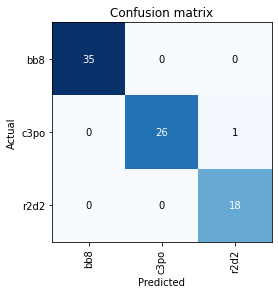

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
learn.export("starwars_bots.pkl")